In [1]:
!git clone https://github.com/ndb796/Face-Mask-Classification-20000-Dataset

Cloning into 'Face-Mask-Classification-20000-Dataset'...
remote: Enumerating objects: 20017, done.
remote: Total 20017 (delta 0), reused 0 (delta 0), pack-reused 20017
Receiving objects: 100% (20017/20017), 600.78 MiB | 43.57 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (20001/20001), done.


In [2]:
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


#### <b>(알아보기) DCGAN 실습 - 모델 정의</b>

* 논문 제목: [Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) <b>(ICLR 2016)</b>
* Convoluational Layer를 활용하여 이미지 생성에 높은 성능을 보이는 DCGAN 모델을 학습해 봅시다.
    * 마스크 착용 여부를 선택하기 위해 <b>조건부(conditional) GAN</b>을 이용합니다.
    * <b>Reference</b>: [Conditional Generative Adversarial Nets (2014)](https://arxiv.org/abs/1411.1784)

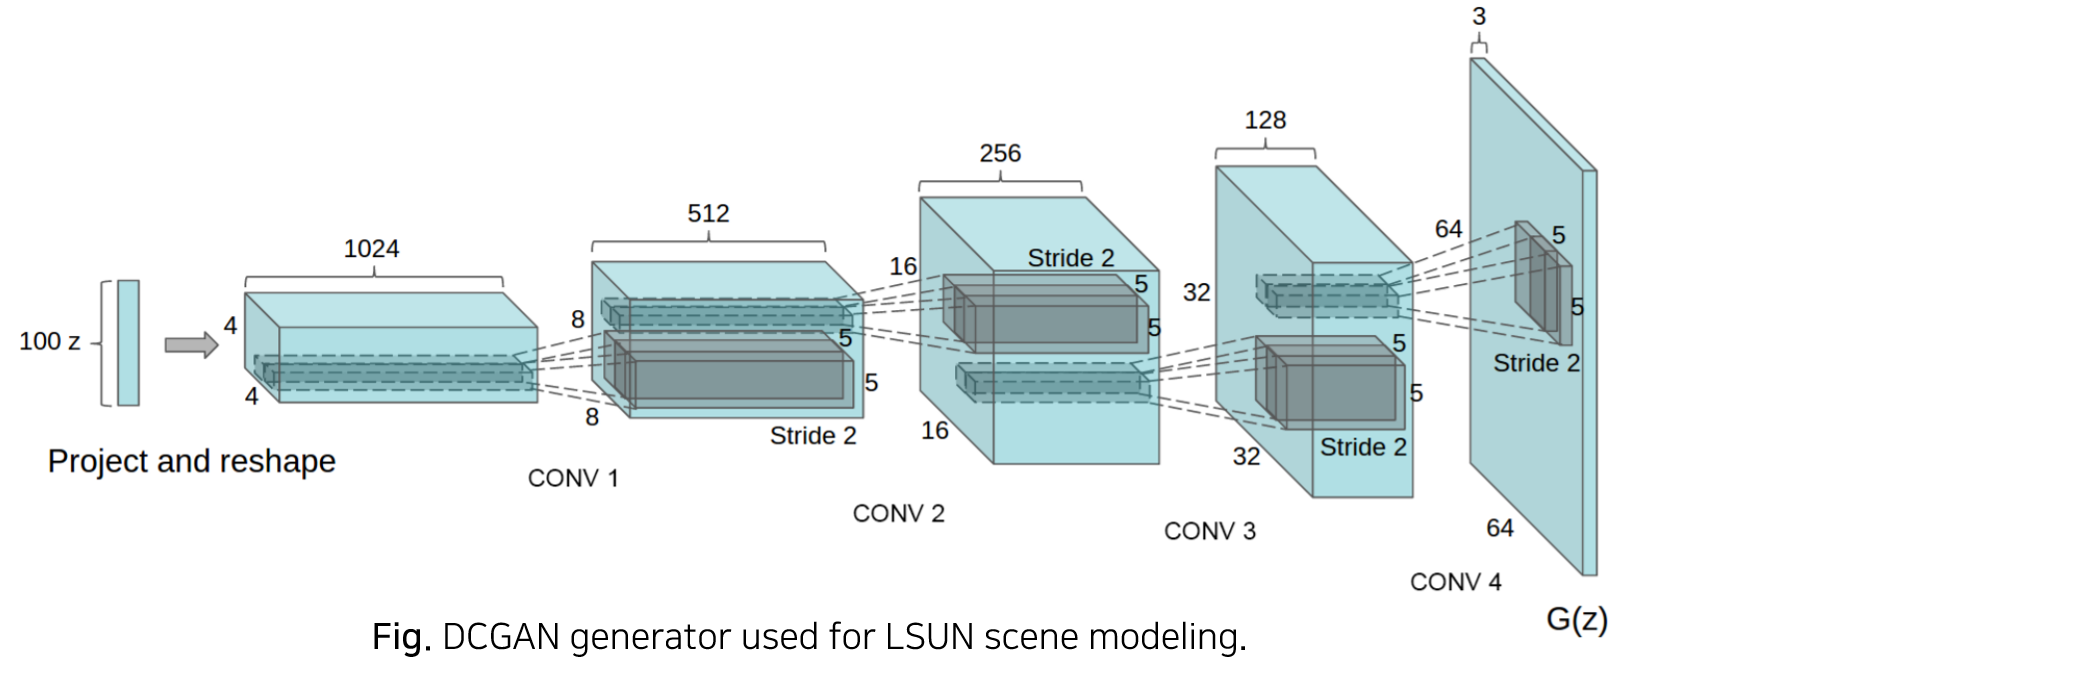

* 생성자(Generator) 및 판별자(Discriminator) 모델을 정의합니다.
    * 생성자 클래스: DCGANGenerator
    * 판별자 클래스: DCGANDiscriminator
* 본 소스코드는 원본 논문에서 제안한 아키텍처와 유사한 아키텍처를 이용합니다.
* <b>Reference</b>: [PyTorch DCGAN 예시 코드](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py)

In [7]:
latent_dim = 100
n_classes = 2


# 생성자(Generator) 클래스 정의
class DCGANGenerator(nn.Module):
    def __init__(self):
        super(DCGANGenerator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.init_size = 4 # 원본 크기보다 16배 작은 값으로 초기화
        self.layer1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 512 * self.init_size * self.init_size)) # 초기 채널의 크기는 512 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 256으로
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 128로
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 3으로
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        # 노이즈(noise) 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        output = self.layer1(inputs)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output


# 판별자(Discriminator) 클래스 정의
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # 너비와 높이가 32배씩 감소
        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, 1 * 64 * 64)

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        # 이미지 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        inputs = torch.cat((img, embed), 1)
        output = self.conv_blocks(inputs)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

#### <b>(알아보기) DCGAN 실습 - 모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
dcgan_generator = DCGANGenerator()
dcgan_discriminator = DCGANDiscriminator()

dcgan_generator.cuda()
dcgan_discriminator.cuda()

# 가중치(weights) 초기화
dcgan_generator.apply(weights_init_normal)
dcgan_discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [9]:
!mkdir -p ./results/dcgan/

n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = dcgan_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(dcgan_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(dcgan_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(dcgan_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = dcgan_generator(z, labels)
            save_image(generated_imgs, f"./results/dcgan/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.3f}] [G loss: {g_loss.item():.3f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/100] [D loss: 0.253673] [G loss: 0.253253] [Elapsed time: 31.33s]
[Epoch 1/100] [D loss: 0.247389] [G loss: 0.256495] [Elapsed time: 62.93s]
[Epoch 2/100] [D loss: 0.251722] [G loss: 0.244603] [Elapsed time: 94.88s]
[Epoch 3/100] [D loss: 0.252583] [G loss: 0.218898] [Elapsed time: 127.15s]
[Epoch 4/100] [D loss: 0.230527] [G loss: 0.278520] [Elapsed time: 159.80s]
[Epoch 5/100] [D loss: 0.251112] [G loss: 0.253929] [Elapsed time: 192.66s]
[Epoch 6/100] [D loss: 0.253576] [G loss: 0.241173] [Elapsed time: 225.62s]
[Epoch 7/100] [D loss: 0.240687] [G loss: 0.256593] [Elapsed time: 258.81s]
[Epoch 8/100] [D loss: 0.254612] [G loss: 0.262751] [Elapsed time: 292.09s]
[Epoch 9/100] [D loss: 0.254396] [G loss: 0.251966] [Elapsed time: 325.38s]
[Epoch 10/100] [D loss: 0.259005] [G loss: 0.263271] [Elapsed time: 358.67s]
[Epoch 11/100] [D loss: 0.247480] [G loss: 0.254241] [Elapsed time: 391.95s]
[Epoch 12/100] [D loss: 0.247858] [G loss: 0.265646] [Elapsed time: 425.29s]
[Epoch 13/10

* 다음의 코드를 이용하여 학습된 모델 파라미터를 저장할 수 있습니다.

In [11]:
# 모델 파라미터 저장
torch.save(dcgan_generator.state_dict(), "DCGAN_Generator_for_Face_Mask.pt")
torch.save(dcgan_discriminator.state_dict(), "DCGAN_Discriminator_for_Face_Mask.pt")
# print("Model saved!")

Model saved!


* 학습된 모델 파라미터를 불러와 이미지 생성을 진행할 수 있습니다.

In [12]:
# 생성자(generator) 초기화
dcgan_generator = DCGANGenerator()
dcgan_generator.cuda()
dcgan_generator.load_state_dict(torch.load("DCGAN_Generator_for_Face_Mask.pt"))
# dcgan_generator.eval()

DCGANGenerator(
  (label_embed): Embedding(2, 2)
  (layer1): Sequential(
    (0): Linear(in_features=102, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode=nearest)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_

#### <b>(알아보기) GAN 모델 평가하기 - FID Score</b>

* 논문 제목: [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567) <b>(CVPR 2016)</b>
* Fréchet Inception Distance(FID) 계산 방법
    * <b>생성된 이미지</b>들과 <b>실제 이미지</b>들을 ImageNet에 넣어 특징(feature)을 추출합니다.
    * 생성된 이미지 특징 분포 G와 실제 이미지 특징 분포 X를 가우시안 분포라고 가정합니다.
    * 두 분포가 얼마나 다른지 계산하기 위해 FID(X, G)를 계산합니다.
* [FID score for PyTorch](https://github.com/hukkelas/pytorch-frechet-inception-distance) 라이브러리를 이용해 간단히 계산할 수 있습니다.
    * 다음과 같이 소스코드를 다운로드할 수 있습니다.

In [15]:
!git clone https://github.com/hukkelas/pytorch-frechet-inception-distance

Cloning into 'pytorch-frechet-inception-distance'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.


* <b>DCGAN</b>: FID 점수를 계산하기 위해 마스크 착용 및 마스크 미착용 이미지를 1,000장씩 생성합니다.

In [27]:
!mkdir -p ./results/dcgan/with_mask
!mkdir -p ./results/dcgan/without_mask

from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/without_mask/{i * 100 + j}.png', normalize=True)

In [28]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/dcgan/without_mask/*.png
Looking for images in ./results/dcgan/without_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
171.6727501957508


In [29]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/dcgan/with_mask/*.png
Looking for images in ./results/dcgan/with_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
114.97265972444866


In [ ]:
# ./results/custom/ 폴더의 모든 파일을 results.zip라는 이름으로 압축
!zip ./results.zip -r ./results/custom/*

In [ ]:
# Google Colab으로부터 results.zip 압축 파일 다운로드
from google.colab import files

files.download('./results.zip')